<h1 style="color:green;">Diabetes Prediction Using Neural Networks</h1>

## Essential Libraries 

In [49]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Required Libraries for Neural Network

In [163]:
import tensorflow
import keras_tuner as kt
from tensorflow import keras
from keras_tuner import RandomSearch
from keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta

## Initial Data Exploration and Analysis

In [3]:
df = pd.read_csv("diabetes.csv")

In [5]:
df.sample(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
447,0,95,80,45,92,36.5,0.330,26,0
569,0,121,66,30,165,34.3,0.203,33,1
425,4,184,78,39,277,37.0,0.264,31,1
652,5,123,74,40,77,34.1,0.269,28,0
653,2,120,54,0,0,26.8,0.455,27,0
711,5,126,78,27,22,29.6,0.439,40,0
65,5,99,74,27,0,29.0,0.203,32,0
479,4,132,86,31,0,28.0,0.419,63,0
53,8,176,90,34,300,33.7,0.467,58,1
705,6,80,80,36,0,39.8,0.177,28,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [9]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [11]:
df.corr()['Outcome']

Pregnancies                 0.221898
Glucose                     0.466581
BloodPressure               0.065068
SkinThickness               0.074752
Insulin                     0.130548
BMI                         0.292695
DiabetesPedigreeFunction    0.173844
Age                         0.238356
Outcome                     1.000000
Name: Outcome, dtype: float64

In [15]:
df = df.drop(columns = ['BloodPressure','SkinThickness'],axis=1)

In [17]:
df.shape

(768, 7)

In [19]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## Separating Features (X) and Target (y)

In [30]:
X = df.drop(columns='Outcome',axis=1)
y = df['Outcome']

In [34]:
X.shape , y.shape

((768, 6), (768,))

In [32]:
X.head()

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,0,33.6,0.627,50
1,1,85,0,26.6,0.351,31
2,8,183,0,23.3,0.672,32
3,1,89,94,28.1,0.167,21
4,0,137,168,43.1,2.288,33


## Check and Fix Distribution (Outliers, Q-Q Plot, and Histogram)

In [62]:
#plot multiple plot in one functions
def All_plot(X):
    col = X.columns
    for column in col:
        if np.issubdtype(X[column].dtype, np.number):  # Check if the column is numeric
            fig, axes = plt.subplots(1, 3, figsize=(21, 6))  # 3 plots in a row
            
            skewness = X[column].skew()
            
            # Determine skewness type
            if skewness > 0:
                skew_type = "Positive Skewness"
            elif skewness < 0:
                skew_type = "Negative Skewness"
            else:
                skew_type = "Approximately Symmetrical"
            
            print(f"{column}: Skewness = {skewness:.2f} ({skew_type})")
            
            # KDE plot
            sns.kdeplot(X[column].dropna(), fill=True, color='blue', alpha=0.5, ax=axes[0])
            axes[0].set_title(f"KDE Plot for {column}\n(Skewness: {skewness:.2f}) ({skew_type})", fontsize=12)
            axes[0].set_xlabel(column)
            axes[0].set_ylabel('Density')
            axes[0].grid(alpha=0.3)
        
            # Q-Q plot
            stats.probplot(X[column].dropna(), dist="norm", plot=axes[1])
            axes[1].set_title(f"Q-Q Plot for {column}", fontsize=12)
            
            # Boxplot
            sns.boxplot(x=X[column], ax=axes[2])
            axes[2].set_title(f"Boxplot for {column}", fontsize=12)
            axes[2].set_xlabel(column)
            
            plt.tight_layout()
            plt.show()

Pregnancies: Skewness = 0.90 (Positive Skewness)


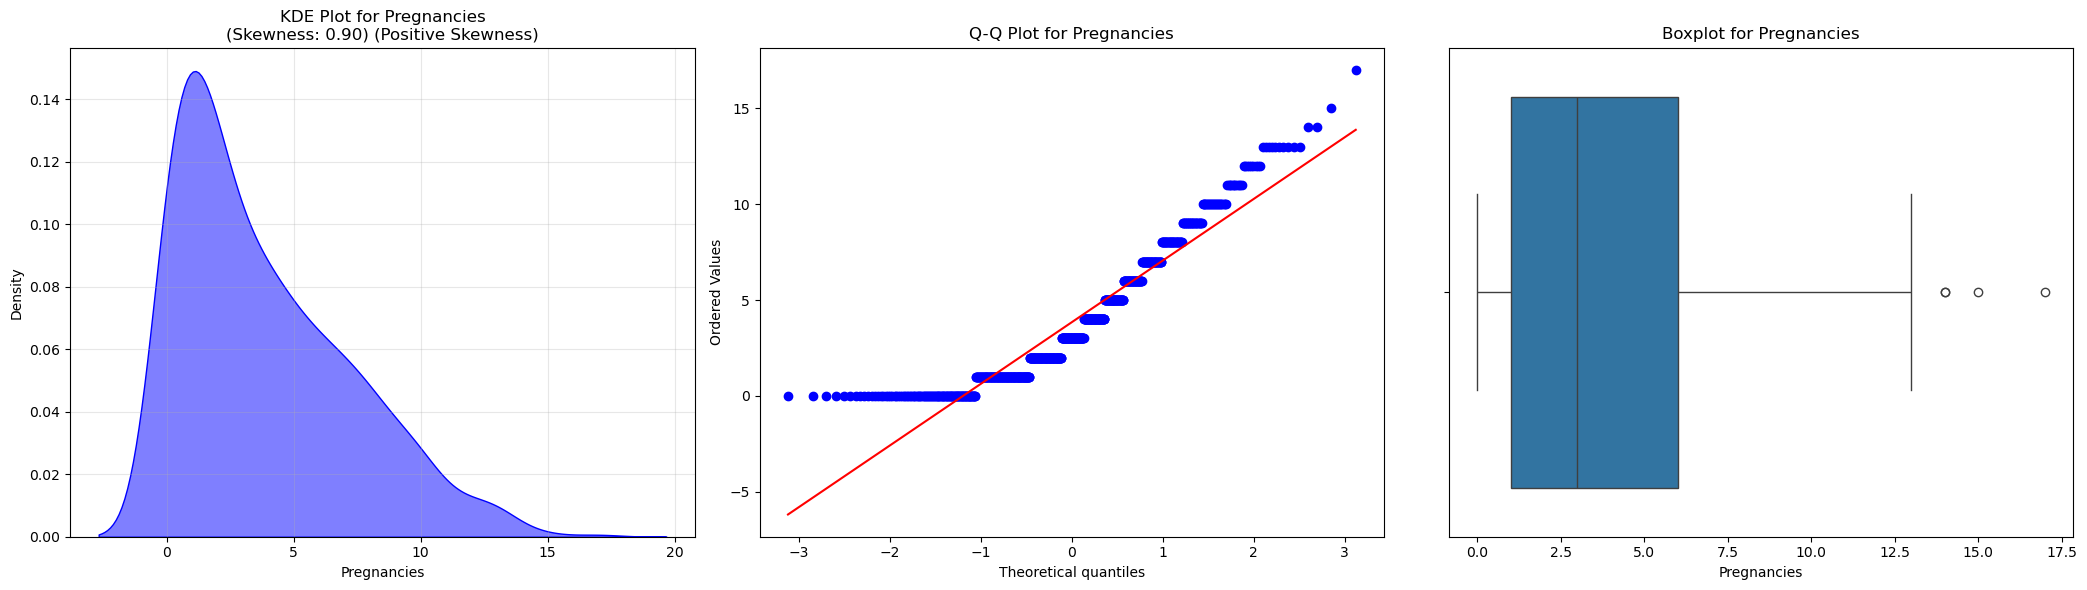

Glucose: Skewness = 0.17 (Positive Skewness)


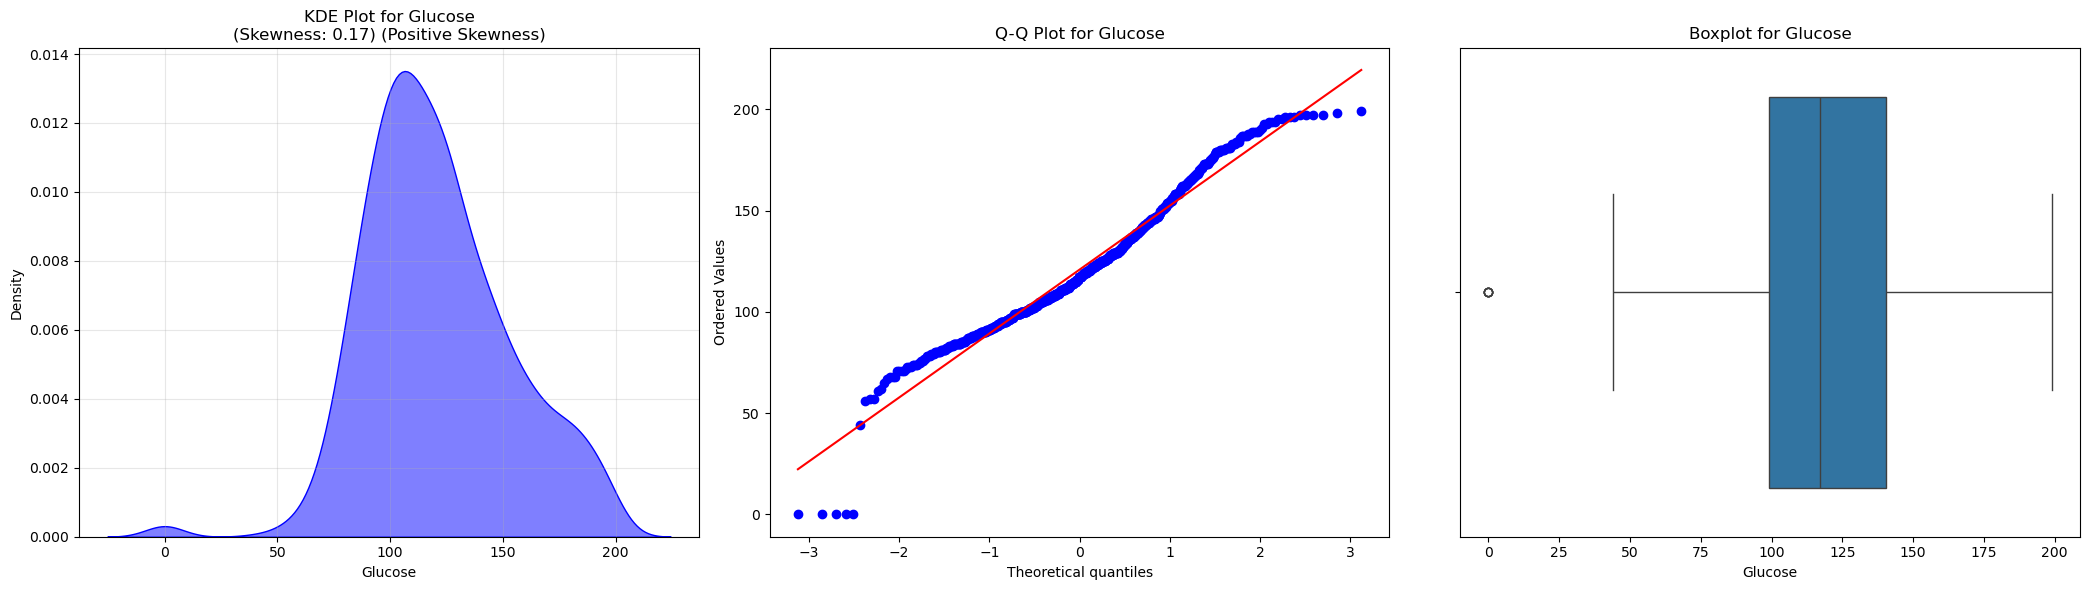

Insulin: Skewness = 2.27 (Positive Skewness)


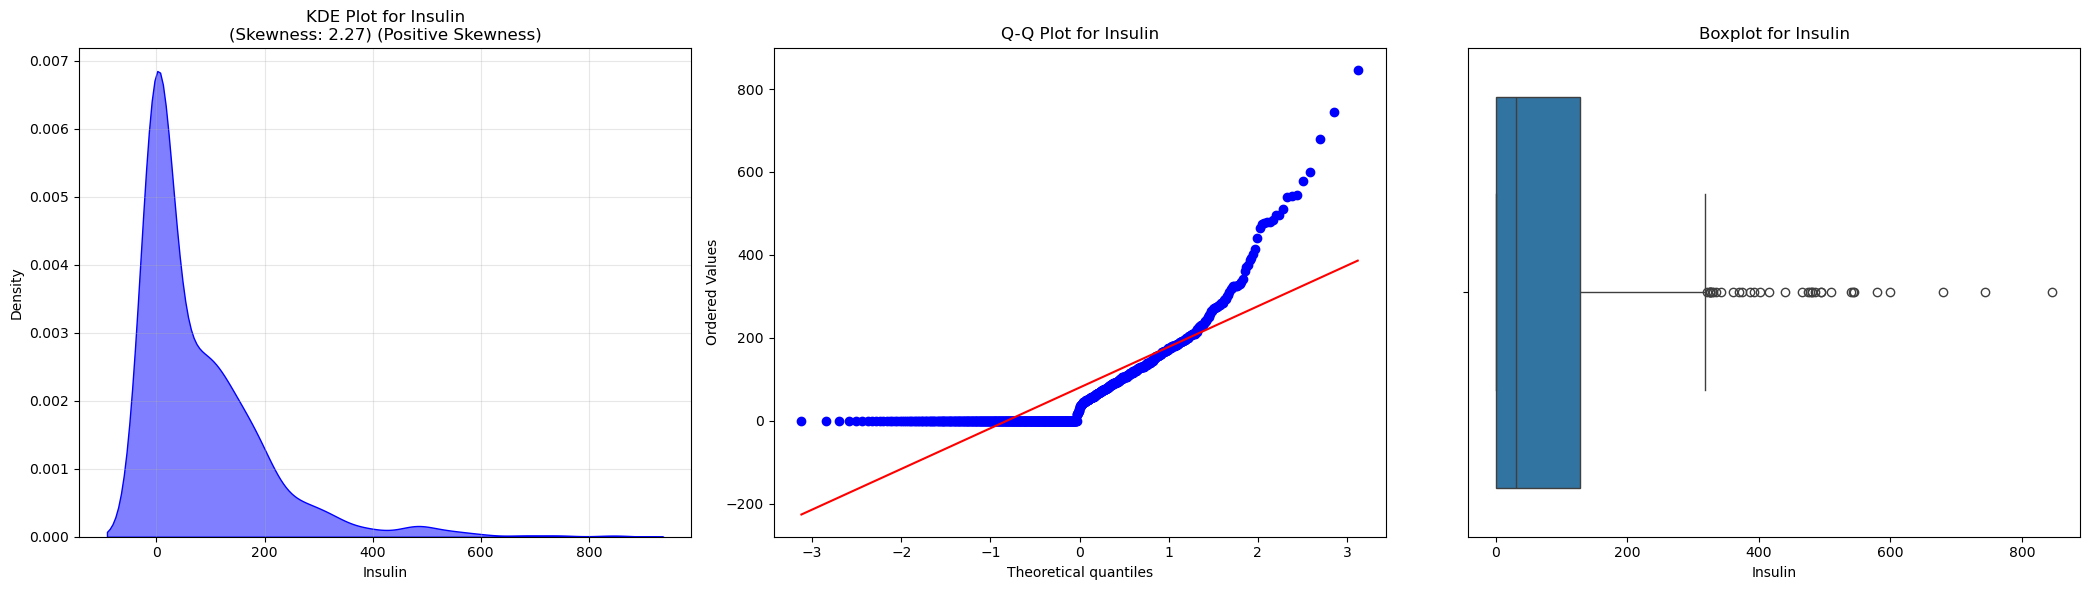

BMI: Skewness = -0.43 (Negative Skewness)


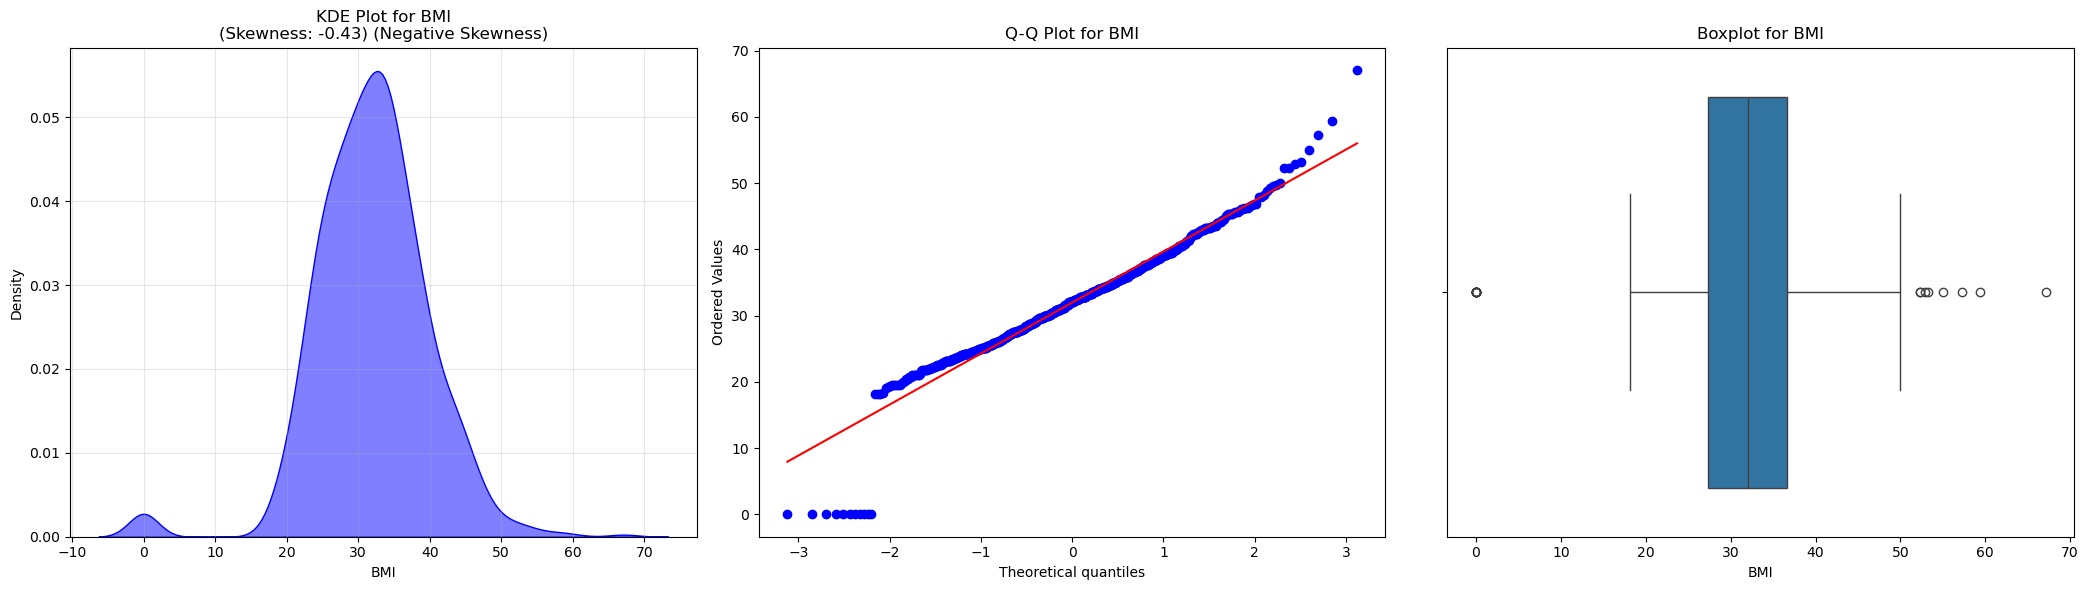

DiabetesPedigreeFunction: Skewness = 1.92 (Positive Skewness)


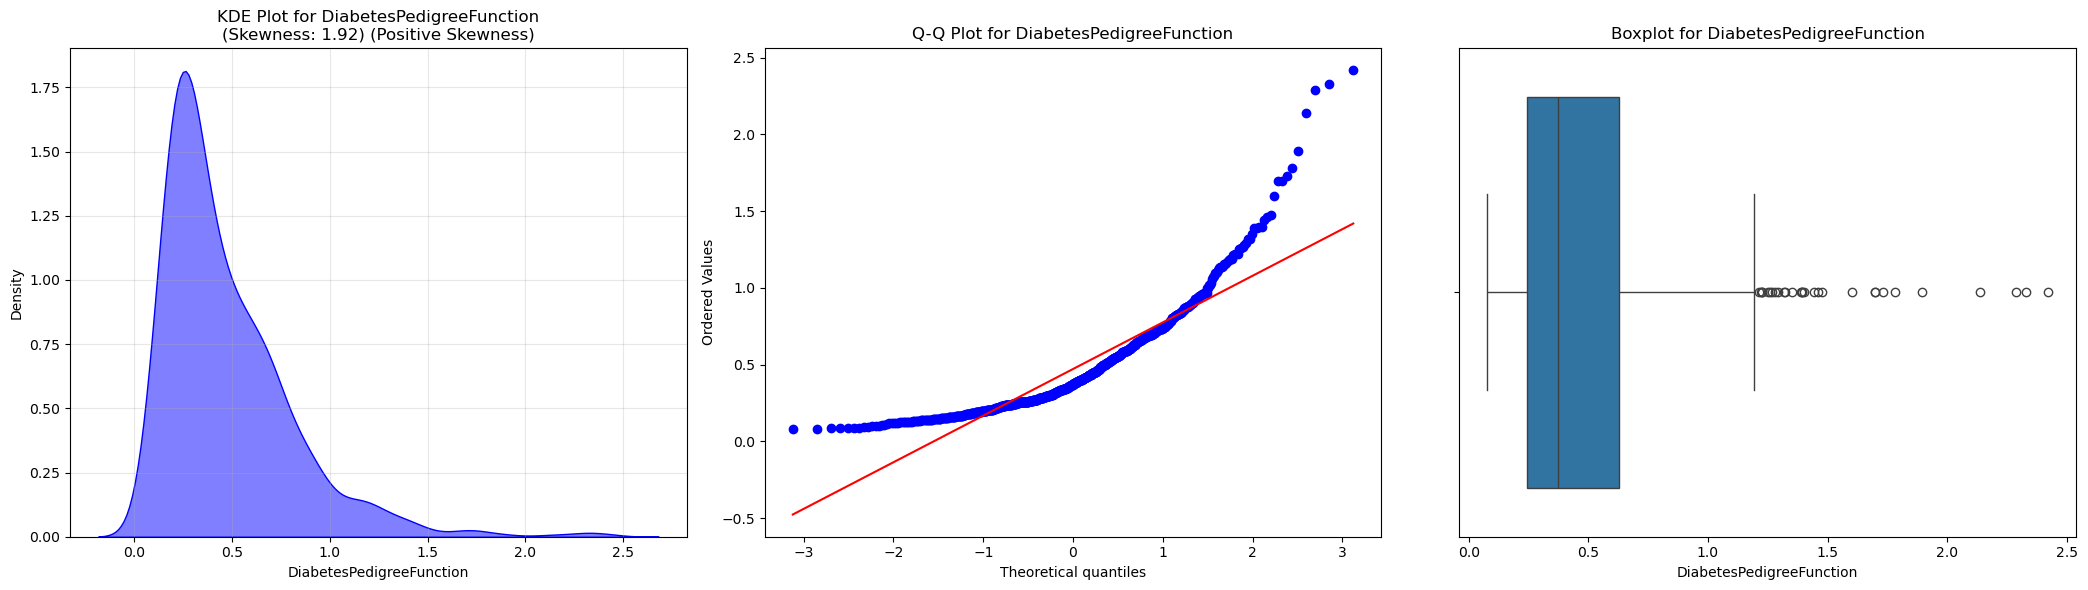

Age: Skewness = 1.13 (Positive Skewness)


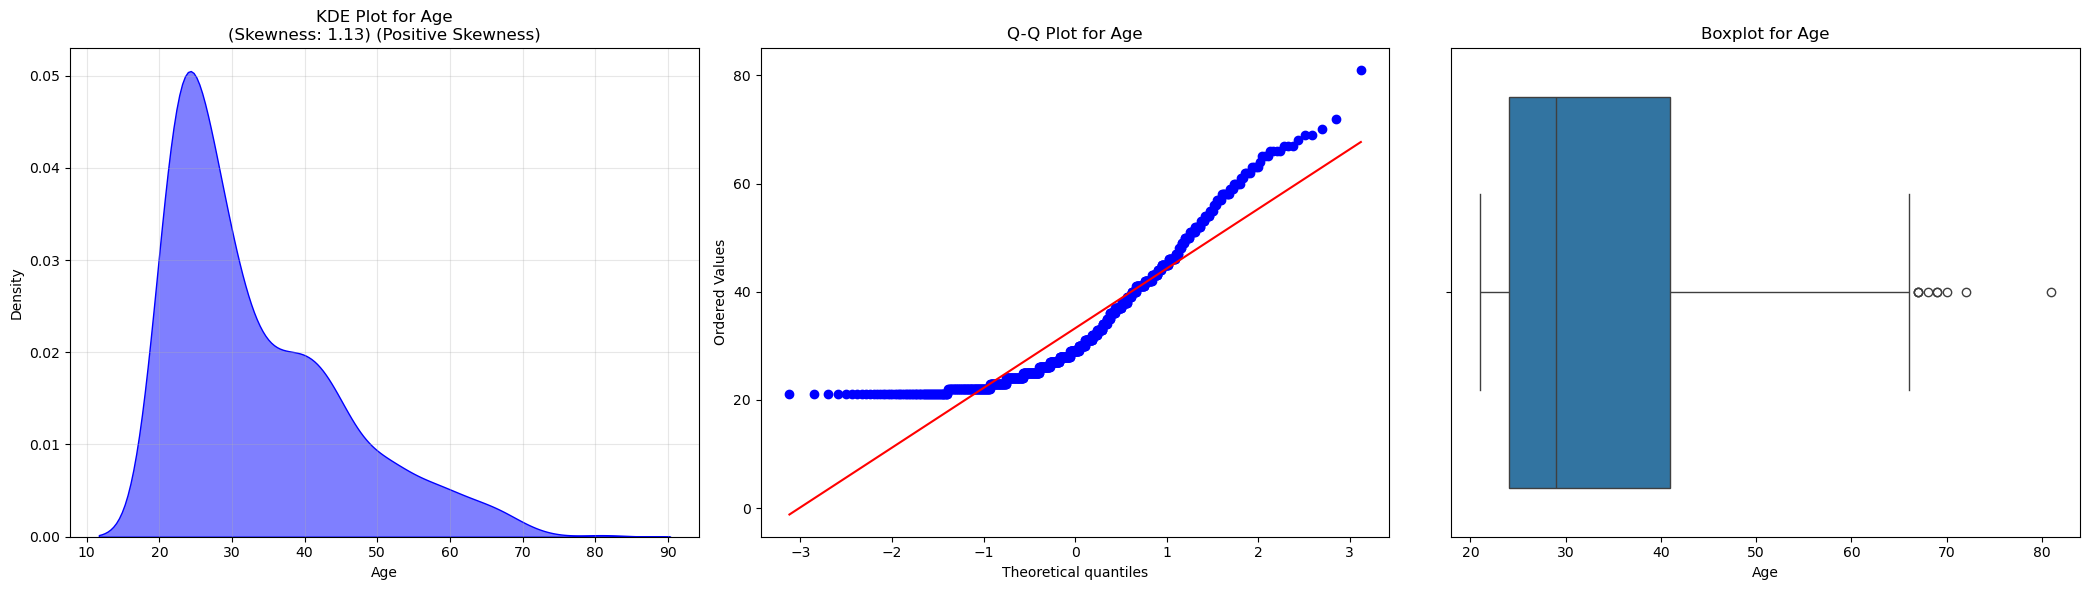

In [64]:
All_plot(X)

## Fix Distribution

In [103]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
import pandas as pd

def Advance_column_transformer(df, columns, method='yeo-johnson', standardize=False):
    """
    Applies PowerTransformer to specific columns using ColumnTransformer,
    keeps other columns unchanged.

    Parameters:
    - df: pandas DataFrame
    - columns: list of column names to transform
    - method: 'yeo-johnson' or 'box-cox'
    - standardize: whether to standardize the output

    Returns:
    - transformed_df: full DataFrame with transformed columns
    - lambdas_df: DataFrame with lambdas for transformed columns
    """
    df_copy = df.copy()

    # Validate columns list
    columns = [col for col in columns if col in df_copy.columns]
    if len(columns) == 0:
        raise ValueError("No valid columns provided for transformation.")

    # Check for missing values in selected columns
    if df_copy[columns].isnull().any().any():
        raise ValueError("Input data contains NaN values. Please impute or drop missing values before transformation.")

    # Box-Cox requires strictly positive values
    if method == 'box-cox':
        for col in columns:
            if (df_copy[col] <= 0).any():
                raise ValueError(f"Box-Cox transformation requires all positive values in column '{col}'")

    # Build ColumnTransformer
    col_transformer = ColumnTransformer(
        transformers=[
            ('power', PowerTransformer(method=method, standardize=standardize), columns)
        ],
        remainder='passthrough'
    )

    # Fit and transform the data
    transformed_array = col_transformer.fit_transform(df_copy)

    # Retrieve columns after transformation
    transformed_feature_names = columns
    passthrough_columns = [col for col in df_copy.columns if col not in columns]
    all_columns_order = transformed_feature_names + passthrough_columns

    # Rebuild DataFrame with correct column order
    transformed_df = pd.DataFrame(transformed_array, columns=all_columns_order, index=df.index)

    # Get lambdas for transformed columns
    fitted_power_transformer = col_transformer.named_transformers_['power']
    lambdas_df = pd.DataFrame({
        'columns': columns,
        'lambdas': fitted_power_transformer.lambdas_
    })

    return transformed_df, lambdas_df


In [105]:
columns = X.columns
columns

Index(['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction',
       'Age'],
      dtype='object')

In [107]:
transformed_X , lambda_df = Advance_column_transformer(X, columns, method='yeo-johnson', standardize=True)

In [120]:
transformed_X.head()

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.813399,0.848665,-1.008294,0.174124,0.821764,1.364180
1,-0.833906,-1.123027,-1.008294,-0.725726,-0.168409,0.126452
2,1.188996,1.930906,-1.008294,-1.129341,0.935284,0.230161
3,-0.833906,-0.996671,0.859700,-0.537700,-1.298725,-1.480075
4,-1.603317,0.506848,1.077013,1.477376,2.336680,0.327328


In [122]:
lambda_df

,columns,lambdas
0,Pregnancies,0.172724
1,Glucose,0.966405
2,Insulin,-0.032285
3,BMI,1.276566
4,DiabetesPedigreeFunction,-2.250387
5,Age,-1.149602


## Check And Remove Outliers 

In [118]:
#detect the outlier columns and plot them 
def outlier(X):
    # Loop through each column in the DataFrame
    for column in X.columns:
        if np.issubdtype(X[column].dtype, np.number):  # Check if the column is numeric
            plt.figure(figsize=(7, 4))
            
            # KDE plot
            sns.boxplot(X[column])
            plt.title(f"boxplot Plot for {column}", fontsize=14)
        
            # plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()

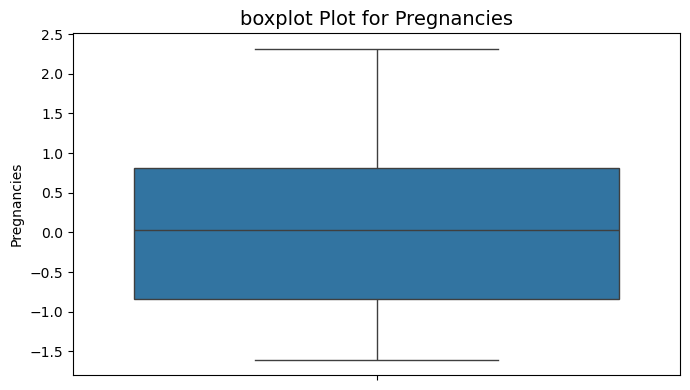

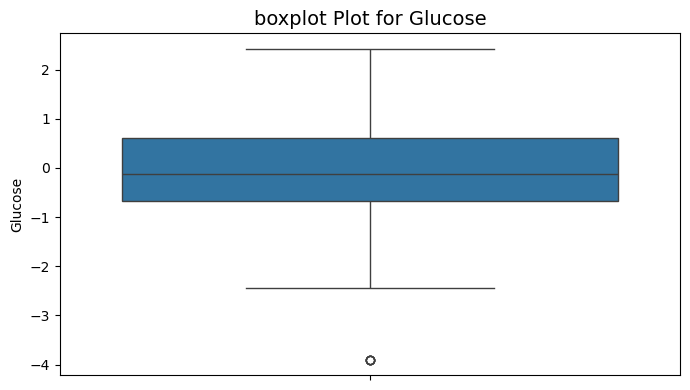

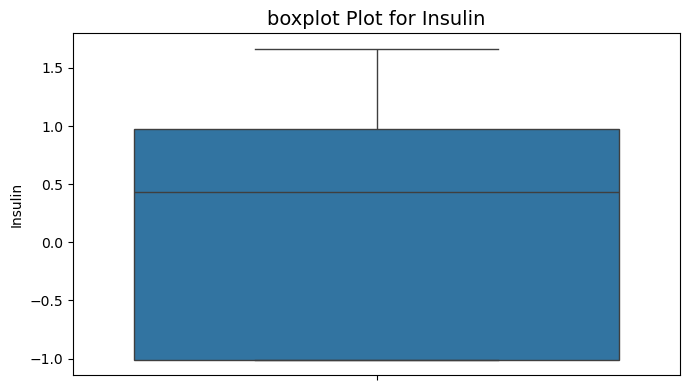

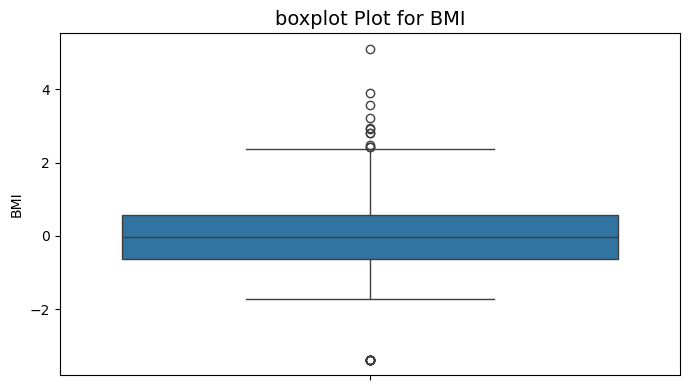

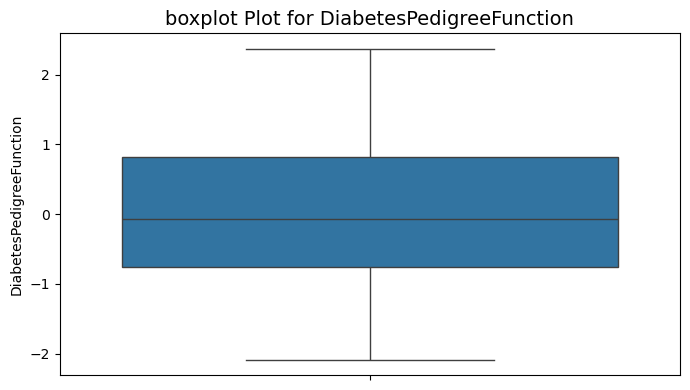

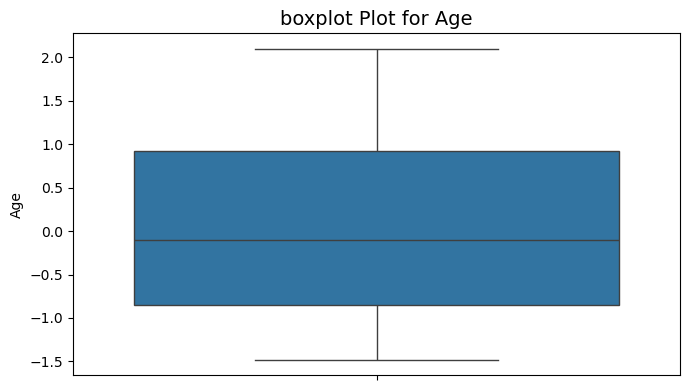

In [125]:
outlier(transformed_X)

In [127]:
# Function to cap outliers using IQR
def cap_outliers_iqr(df):
    df_capped = df.copy()  # Make a copy to avoid modifying the original DataFrame

    # Loop through numeric columns and cap outliers based on IQR
    for column in df_capped.select_dtypes(include=[np.number]).columns:
        Q1 = df_capped[column].quantile(0.25)
        Q3 = df_capped[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Cap values outside the bounds to the lower or upper bound
        df_capped[column] = np.clip(df_capped[column], lower_bound, upper_bound)

    return df_capped

In [129]:
X_final = cap_outliers_iqr(transformed_X)

Pregnancies: Skewness = -0.04 (Negative Skewness)


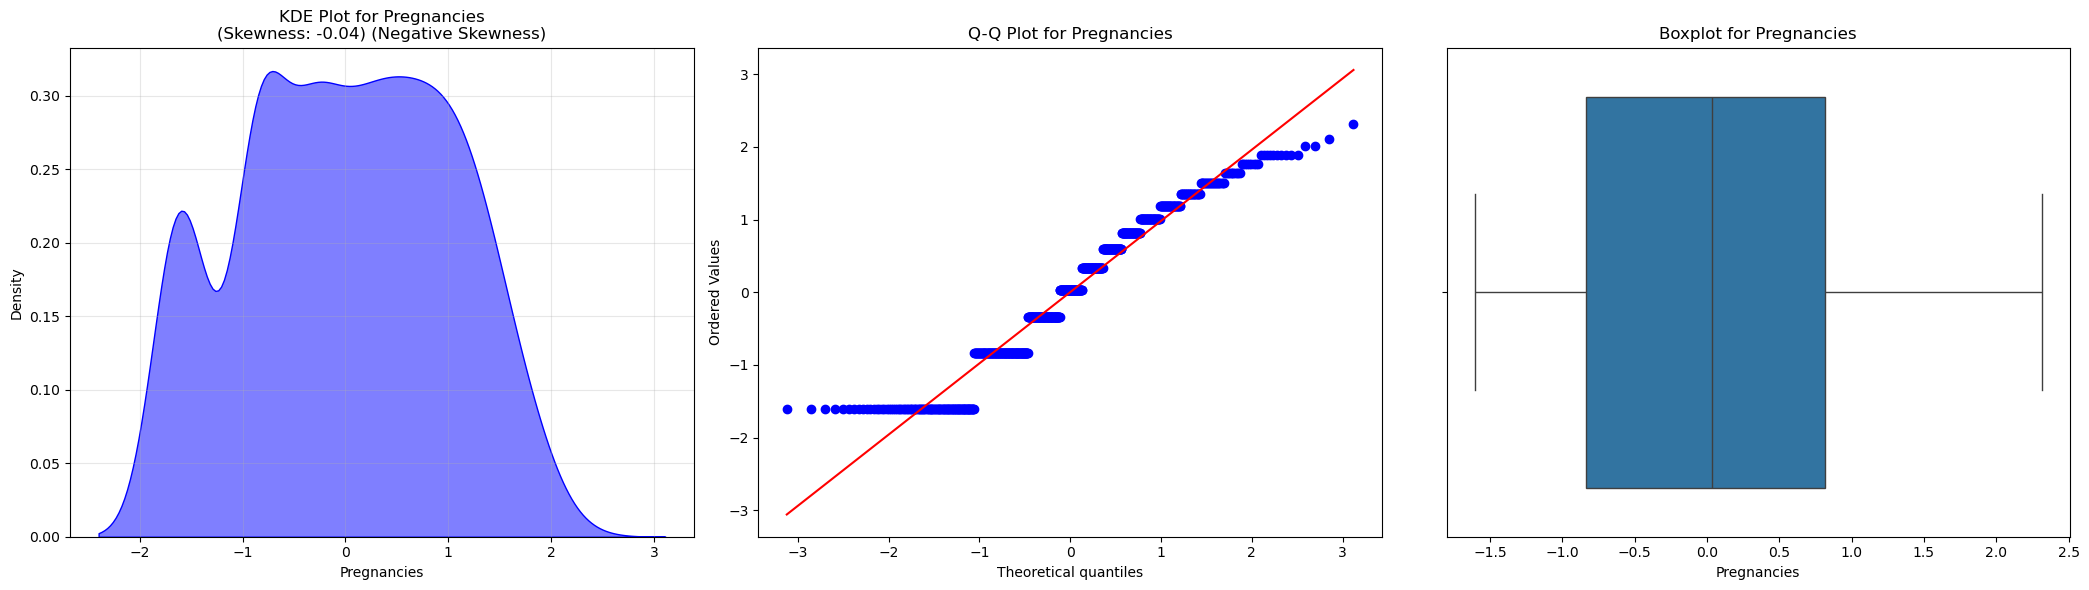

Glucose: Skewness = 0.40 (Positive Skewness)


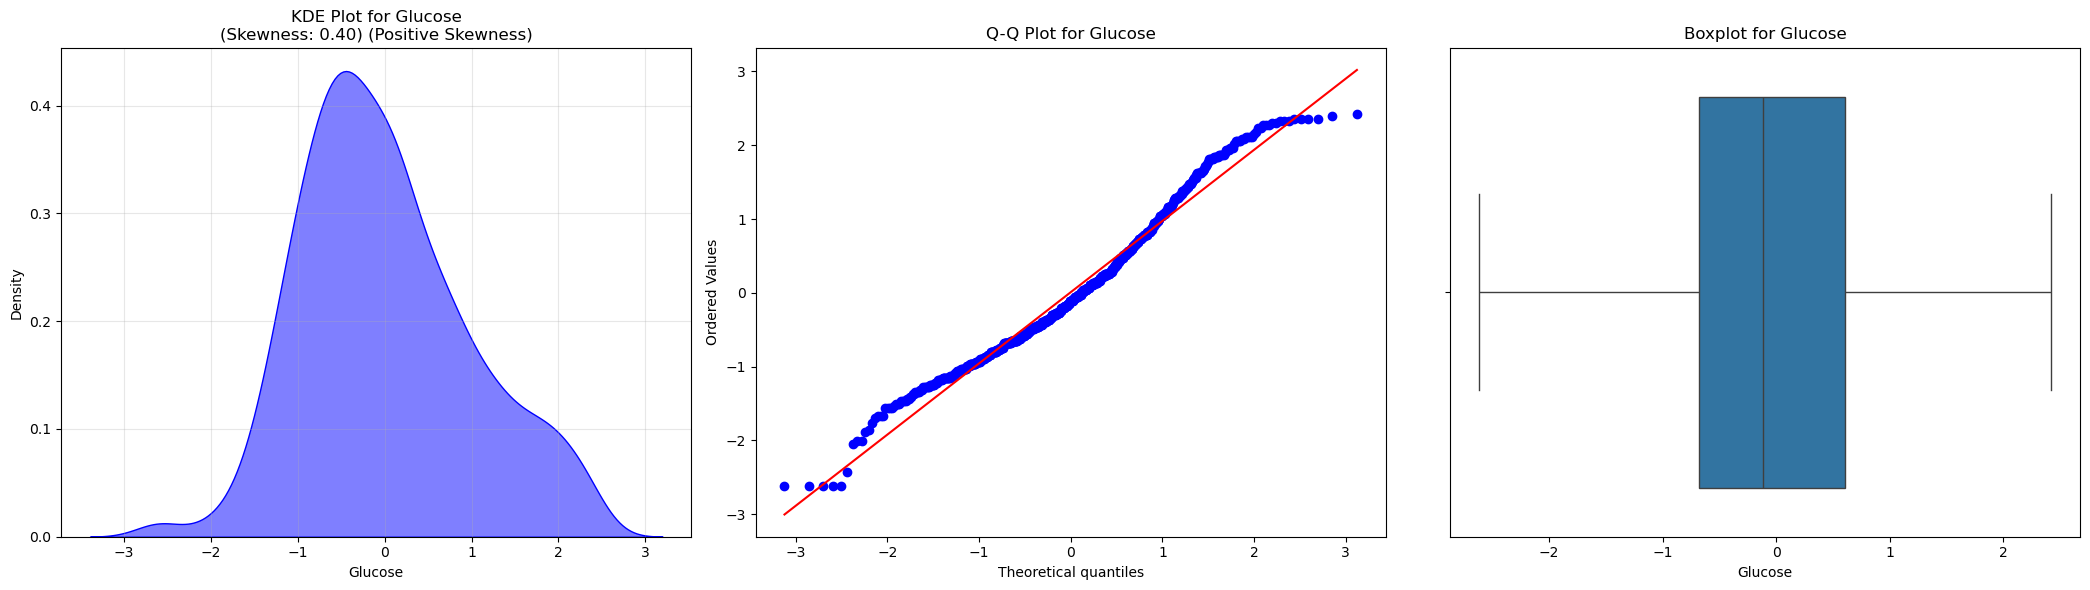

Insulin: Skewness = 0.05 (Positive Skewness)


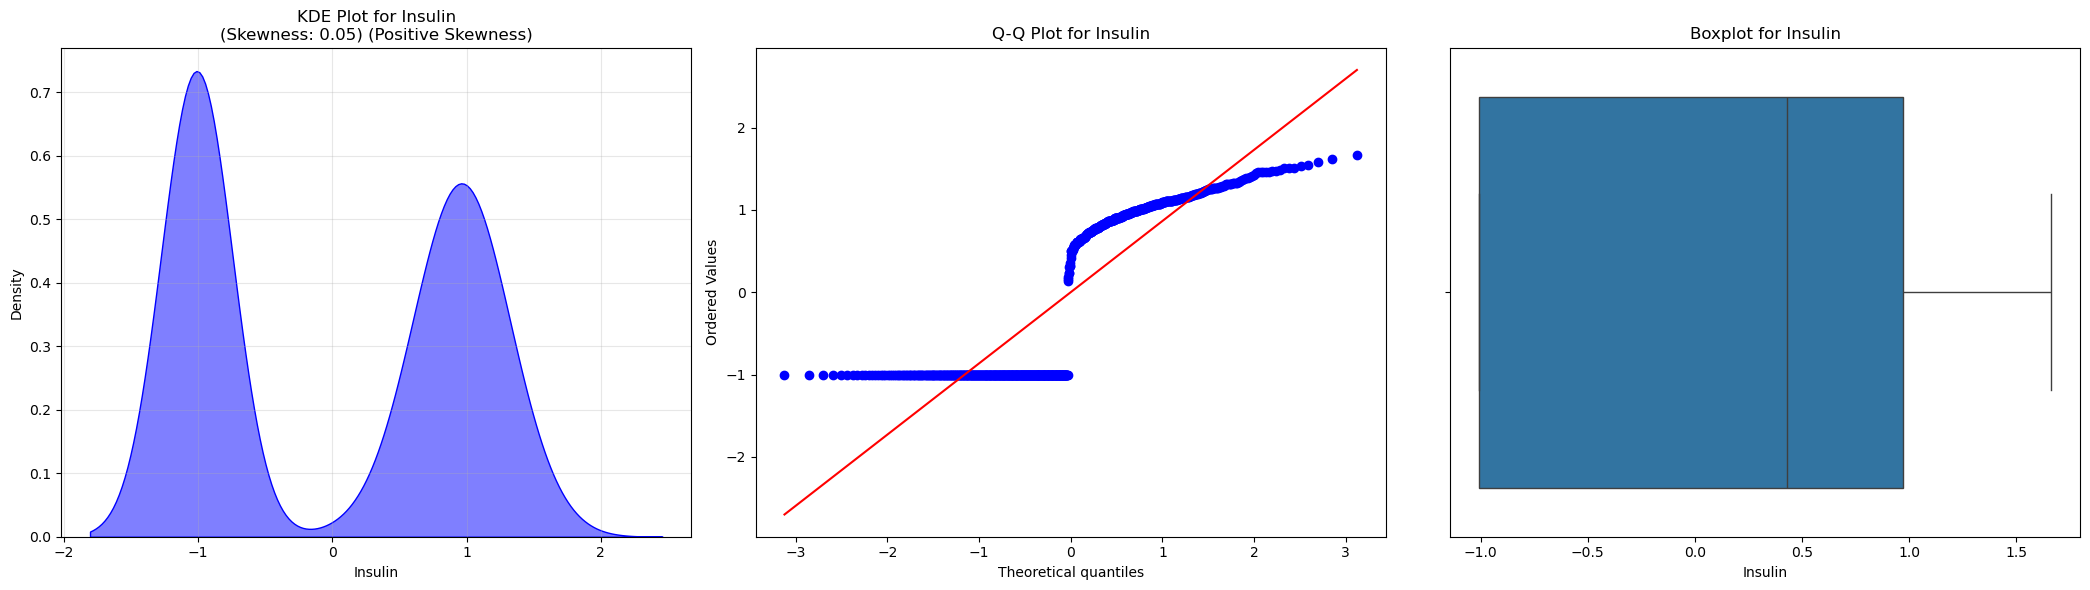

BMI: Skewness = 0.22 (Positive Skewness)


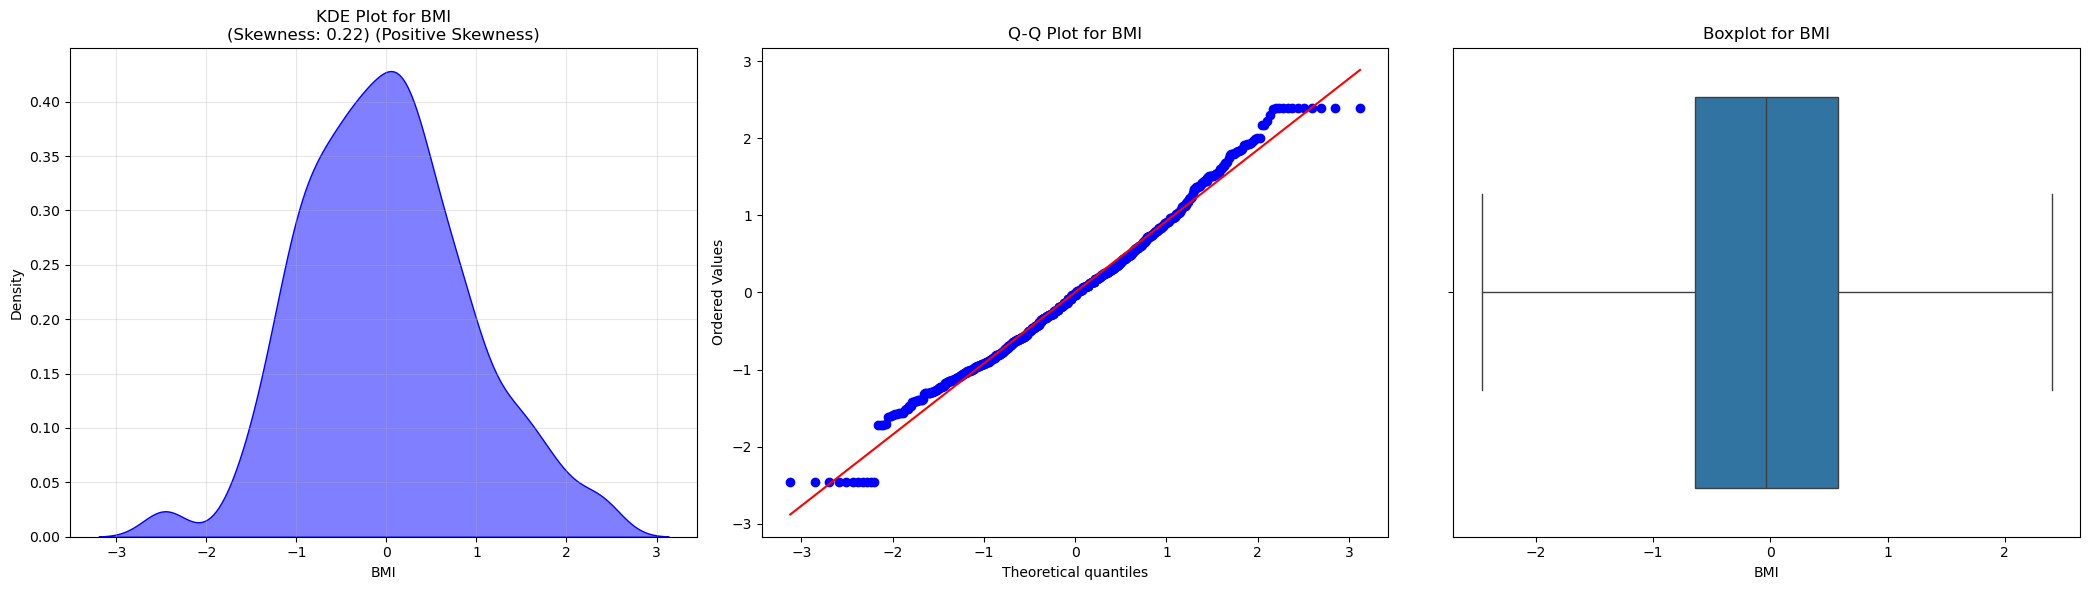

DiabetesPedigreeFunction: Skewness = 0.14 (Positive Skewness)


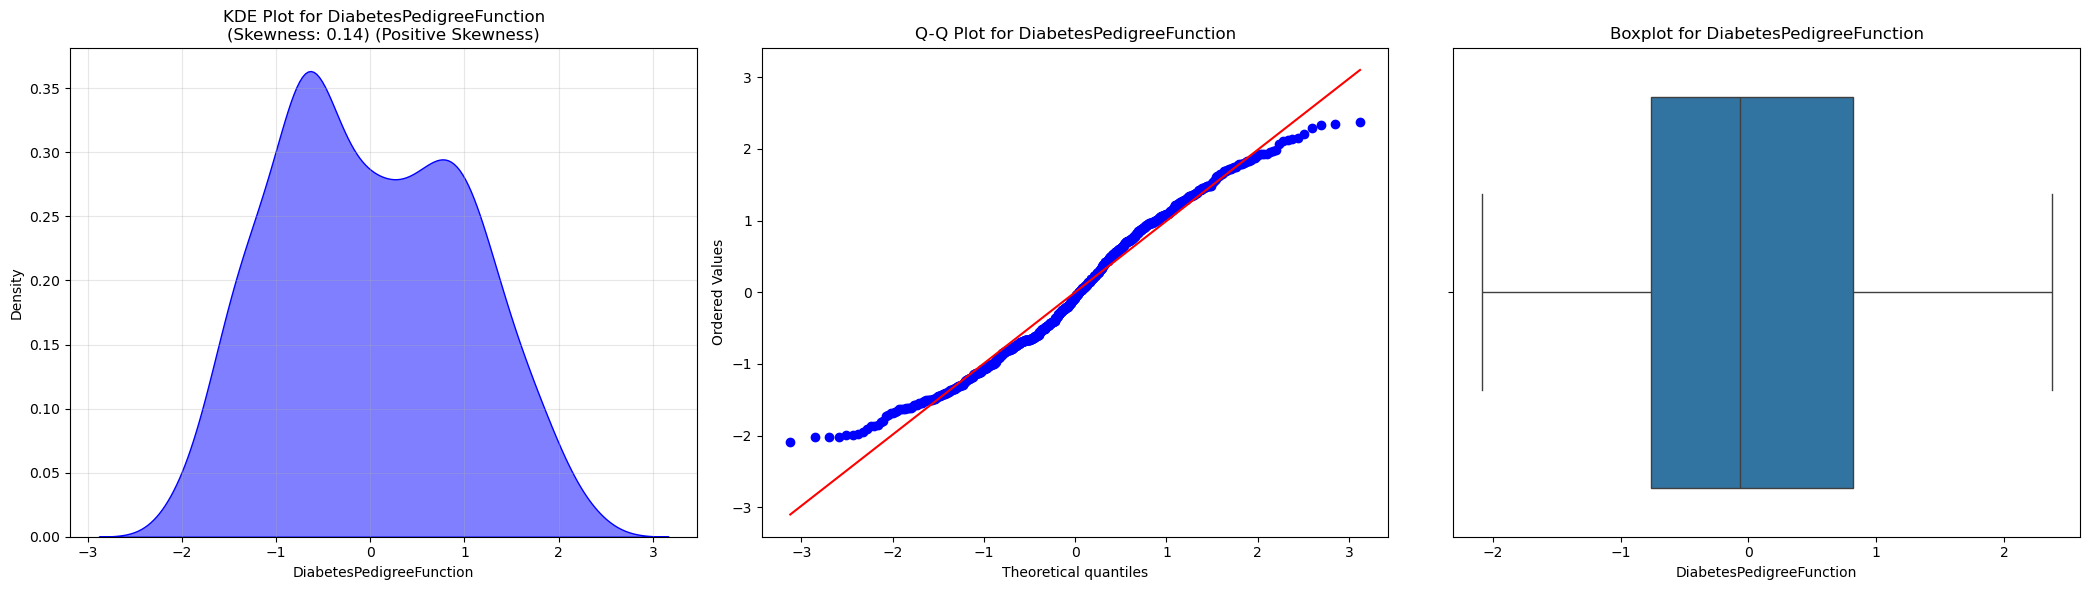

Age: Skewness = 0.15 (Positive Skewness)


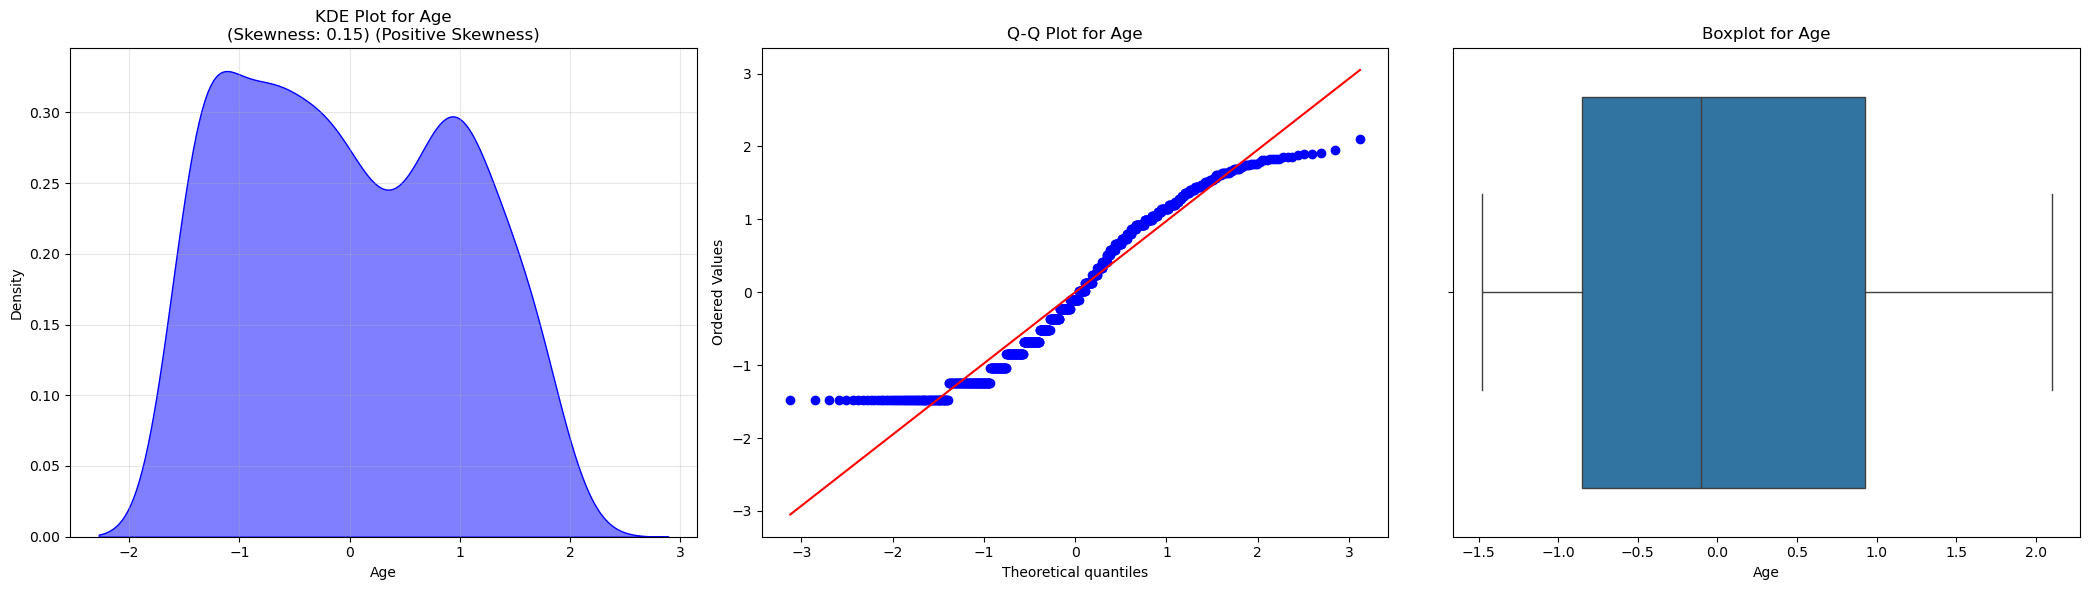

In [133]:
All_plot(X_final)

## Check Class Balance (for classification target)

In [138]:
y.value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [140]:
import matplotlib.pyplot as plt

def plot_class_balance(y, figsize=(12,5), bar_color='skyblue', pie_colors=None):
    """
    Plots class distribution of target variable y using bar chart and pie chart side by side.

    Parameters:
    - y: pandas Series or list/array of target labels
    - figsize: tuple, size of the matplotlib figure
    - bar_color: color of bars in bar chart
    - pie_colors: list of colors for pie chart slices, optional

    Returns:
    - None (displays plots)
    """
    # Convert y to pandas Series if not already
    import pandas as pd
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    counts = y.value_counts().sort_index()
    labels = counts.index.astype(str)
    sizes = counts.values

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Bar Chart
    axes[0].bar(labels, sizes, color=bar_color)
    axes[0].set_title('Class Distribution - Bar Chart')
    axes[0].set_xlabel('Classes')
    axes[0].set_ylabel('Counts')

    for i, count in enumerate(sizes):
        axes[0].text(i, count + max(sizes)*0.01, str(count), ha='center')

    # Pie Chart
    axes[1].pie(sizes, labels=labels, autopct='%1.1f%%', colors=pie_colors, startangle=90, counterclock=False)
    axes[1].set_title('Class Distribution - Pie Chart')

    plt.tight_layout()
    plt.show()


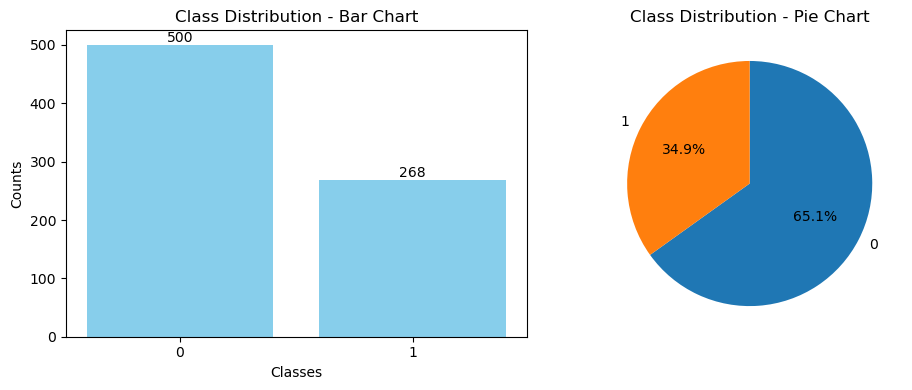

In [155]:
# Example usage with y as a pandas Series
plot_class_balance(y,figsize=(10,4))

## Splitting Dataset for Model Training and Evaluation

In [158]:
X_train,X_test,y_train,y_test = train_test_split(X_final,y,test_size=0.2,random_state=42)

In [160]:
X_train.shape ,X_test.shape ,y_train.shape ,y_test.shape

((614, 6), (154, 6), (614,), (154,))

## Train Neural Network with Keras Tuner

## Find Optimal Hyperparameters Using Keras Tuner

In [230]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(6,)))
    #for finding optimal layers
    for i in range(hp.Int('num_layers',min_value=1,max_value=10)):
        #find optimal layers
            model.add(
                Dense(
                    hp.Int('units-'+str(i),min_value=8,max_value=128,step=8),# for optimal node in every layers
                    activation = hp.Choice('activation'+str(i),values=['relu','tanh','selu']),#optimal activation
                )
            )
        #find optimal dropout layer value
            model.add(Dropout(hp.Choice('dropout-'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])))
            
    model.add(Dense(1,activation='sigmoid'))

    #optimal optimizer
    optimizers_list = hp.Choice('optimizers',values = ['adam','sgd','rmsprop','adadelta'])
    model.compile(optimizer=optimizers_list,loss='binary_crossentropy',metrics=['accuracy'])

    return model

In [232]:
tuner = kt.RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials=10,
    max_retries_per_trial=1,
    directory='model_tuner',
    project_name='my_model_tuning'
)

In [234]:
tuner.search(X_train,y_train,epochs=50,validation_data=(X_test,y_test))

Trial 10 Complete [00h 00m 19s]
val_accuracy: 0.6428571343421936

Best val_accuracy So Far: 0.7922077775001526
Total elapsed time: 00h 03m 04s


## Retrieve Best Hyperparameters from Tuner

In [237]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 5,
 'units-0': 64,
 'activation0': 'relu',
 'dropout-0': 0.4,
 'optimizers': 'adam',
 'units-1': 40,
 'activation1': 'relu',
 'dropout-1': 0.3,
 'units-2': 16,
 'activation2': 'selu',
 'dropout-2': 0.8,
 'units-3': 128,
 'activation3': 'tanh',
 'dropout-3': 0.3,
 'units-4': 120,
 'activation4': 'relu',
 'dropout-4': 0.6,
 'units-5': 32,
 'activation5': 'tanh',
 'dropout-5': 0.5,
 'units-6': 56,
 'activation6': 'tanh',
 'dropout-6': 0.7,
 'units-7': 56,
 'activation7': 'selu',
 'dropout-7': 0.9}

## Retrieve the Best Trained Model from Tuner

In [367]:
model = tuner.get_best_models(num_models=1)[0]

C:\Users\parvez\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [368]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 40)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 120)                 │          15,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,481 (83.91 KB)

 Trainable params: 21,481 (83.91 KB)

 Non-trainable params: 0 (0.00 B)

## Implement EarlyStopping to Prevent Overfitting

In [370]:
# from tensorflow.keras.callbacks import EarlyStopping
# early_stop = EarlyStopping(
#     monitor='val_accuracy',     # or 'val_accuracy'
#     patience=40,             # how many epochs to wait after no improvement
#     restore_best_weights=True  # revert to best weights after training
# )

from tensorflow.keras.callbacks import Callback
import numpy as np

class AccuracyGapEarlyStopping(Callback):
    def __init__(self, threshold=0.01, patience=5):
        super().__init__()
        self.threshold = threshold
        self.patience = patience
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        gap = abs(acc - val_acc)

        if gap < self.threshold:
            self.wait += 1
            print(f"Accuracy gap {gap:.4f} is below threshold. Patience count: {self.wait}/{self.patience}")
            if self.wait >= self.patience:
                print("Stopping training early due to small accuracy gap.")
                self.model.stop_training = True
        else:
            self.wait = 0  # reset if gap grows


In [374]:
gap_stop = AccuracyGapEarlyStopping(threshold=0.01, patience=10)

## Train the Best_model

In [377]:
history = model.fit(X_train,y_train,epochs=200,initial_epoch=50,validation_data=(X_test,y_test), callbacks=[gap_stop])

Epoch 51/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6945 - loss: 0.6042 - val_accuracy: 0.7468 - val_loss: 0.5109
Epoch 52/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6947 - loss: 0.5584 - val_accuracy: 0.7597 - val_loss: 0.5088
Epoch 53/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6856 - loss: 0.5692 - val_accuracy: 0.7597 - val_loss: 0.5054
Epoch 54/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7168 - loss: 0.5305 - val_accuracy: 0.7792 - val_loss: 0.5025
Epoch 55/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7586 - loss: 0.5157 - val_accuracy: 0.7727 - val_loss: 0.5017
Epoch 56/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7465 - loss: 0.5177 - val_accuracy: 0.7532 - val_loss: 0.5029
Epoch 57/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7638 - loss: 0.5060 - val_accuracy: 0.7597 - val_loss: 0.5046
Epoch 58/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7196 - loss: 0.5250 - val_accuracy: 0

## Plot Training and Validation Accuracy & Loss Side by Side

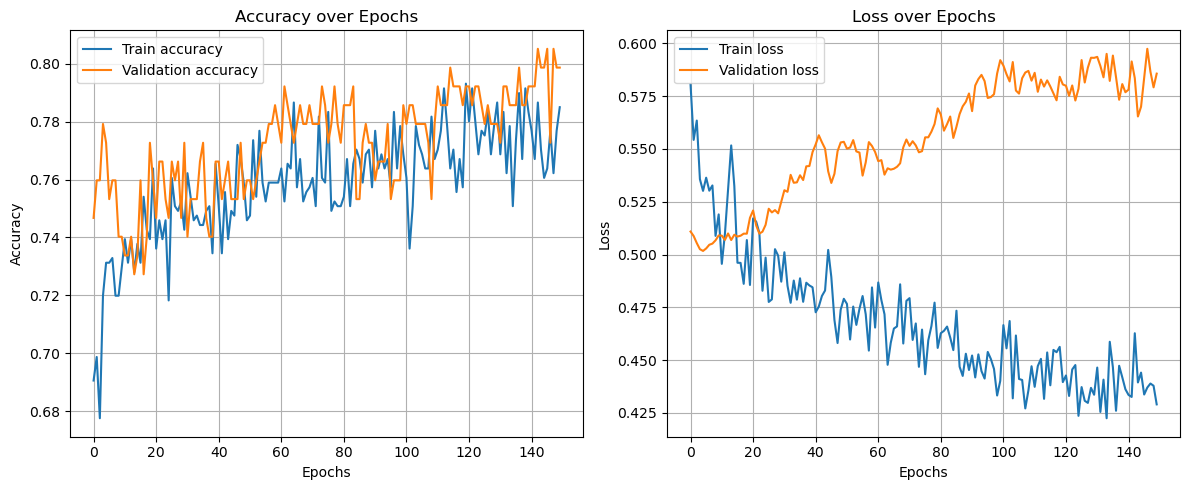

In [379]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
axs[0].plot(history.history['accuracy'], label='Train accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)
axs[0].set_title('Accuracy over Epochs')

# Loss plot
axs[1].plot(history.history['loss'], label='Train loss')
axs[1].plot(history.history['val_loss'], label='Validation loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)
axs[1].set_title('Loss over Epochs')

plt.tight_layout()
plt.show()

## Predict on Test Data and Evaluate Model Accuracy

In [381]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype("int32")
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy of the model is : ",accuracy)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Accuracy of the model is :  0.7987012987012987


## Plot Confusion Matrix to Evaluate Classification Performance

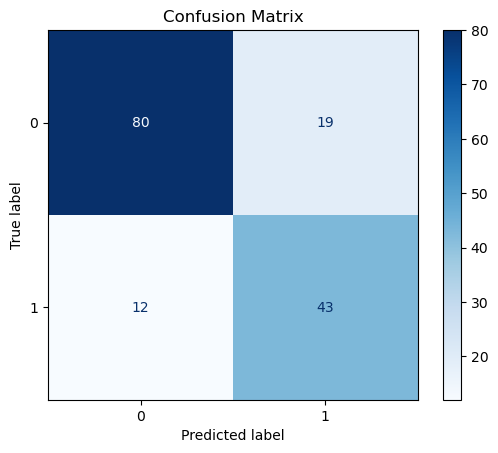

In [383]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Calculate and Display F1 Scores for the Model

In [385]:
#calculate F1 score 
def All_F1_score(y_test, y_pred):
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    # Compute F1 Scores
    f1_micro = f1_score(y_test, y_pred, average='micro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    # Print Results
    print(f"Micro F1 Score: {f1_micro}")
    print(f"Macro F1 Score: {f1_macro}")
    print(f"Weighted F1 Score: {f1_weighted}")

In [386]:
All_F1_score(y_test, y_pred)

Micro F1 Score: 0.7987012987012987
Macro F1 Score: 0.7863695350606346
Weighted F1 Score: 0.8010343350657487
